In [1]:
import tifffile
import h5py
import os
import random
from datetime import datetime
import numpy as np
import torch
import rasterio
from rasterio.plot import show

from scipy.interpolate import griddata



# Dữ liệu ảnh Radar

*  Khoảng thời gian: tháng 4, 10 năm 2019, 2020
*  Độ phân giải không gian: 0.04 độ ~ 4KM
*  Độ phân giải thời gian: 1 giờ






THÔNG TIN ẢNH RADAR 0h-01/04/2019:
- Kích thước ảnh (bands, height, width): (1, 90, 250)
- Hệ tọa độ CRS: EPSG:4326
Độ phân giải không gian:
  + Theo chiều ngang (X / Lon): 0.04
  + Theo chiều dọc (Y / Lat): 0.04
Bounding Box:
  + Góc trên-trái:    (101.0, 21.1)
  + Góc dưới-phải:    (111.0, 17.5)
Tọa độ tâm ảnh:
  + (106.0, 19.3)


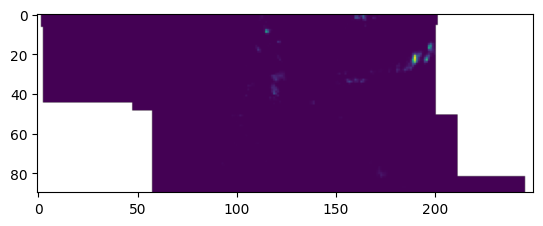

In [2]:
tiff_file = './dataset/2019/04/01/Radar_20190401000000.tif'

with rasterio.open(tiff_file) as image:
    transform = image.transform
    crs = image.crs
    bounds = image.bounds
    width = image.width
    height = image.height
    band = image.count

    # Độ phân giải không gian
    pixel_width = transform.a
    pixel_height = -transform.e

    center_x = bounds.left + (bounds.right - bounds.left) / 2
    center_y = bounds.bottom + (bounds.top - bounds.bottom) / 2

    print("THÔNG TIN ẢNH RADAR 0h-01/04/2019:")
    print(f"- Kích thước ảnh (bands, height, width): ({band}, {height}, {width})")
    print(f"- Hệ tọa độ CRS: {crs}")
    print("Độ phân giải không gian:")
    print(f"  + Theo chiều ngang (X / Lon): {pixel_width}")
    print(f"  + Theo chiều dọc (Y / Lat): {pixel_height}")
    print("Bounding Box:")
    print(f"  + Góc trên-trái:    ({bounds.left}, {bounds.top})")
    print(f"  + Góc dưới-phải:    ({bounds.right}, {bounds.bottom})")
    print("Tọa độ tâm ảnh:")
    print(f"  + ({center_x}, {center_y})")
    image_array = image.read(1)


    show(image_array)


THÔNG TIN ẢNH RADAR 0h-01/04/2020:
- Kích thước ảnh (bands, height, width): (1, 90, 250)
- Hệ tọa độ CRS: EPSG:4326
Độ phân giải không gian:
  + Theo chiều ngang (X / Lon): 0.04
  + Theo chiều dọc (Y / Lat): 0.04
Bounding Box:
  + Góc trên-trái:    (101.0, 21.1)
  + Góc dưới-phải:    (111.0, 17.5)
Tọa độ tâm ảnh:
  + (106.0, 19.3)


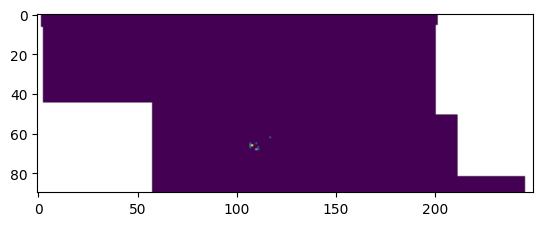

In [3]:
tiff_file = './dataset/2020/04/01/Radar_20200401000000.tif'

with rasterio.open(tiff_file) as image:
    transform = image.transform
    crs = image.crs
    bounds = image.bounds
    width = image.width
    height = image.height
    band = image.count

    # Độ phân giải không gian
    pixel_width = transform.a
    pixel_height = -transform.e

    # Tọa độ góc trên-trái
    top_left_x, top_left_y = transform * (0, 0)  # (col, row) = (0, 0) là góc trên-trái
    # Tọa độ góc dưới-phải
    bottom_right_x, bottom_right_y = transform * (width, height)  # (col, row) = (width, height) là góc dưới-phải

    # Tọa độ tâm ảnh (giả định vị trí radar)
    center_x = bounds.left + (bounds.right - bounds.left) / 2
    center_y = bounds.bottom + (bounds.top - bounds.bottom) / 2

    print("THÔNG TIN ẢNH RADAR 0h-01/04/2020:")
    print(f"- Kích thước ảnh (bands, height, width): ({band}, {height}, {width})")
    print(f"- Hệ tọa độ CRS: {crs}")
    print("Độ phân giải không gian:")
    print(f"  + Theo chiều ngang (X / Lon): {pixel_width}")
    print(f"  + Theo chiều dọc (Y / Lat): {pixel_height}")
    print("Bounding Box:")
    print(f"  + Góc trên-trái:    ({bounds.left}, {bounds.top})")
    print(f"  + Góc dưới-phải:    ({bounds.right}, {bounds.bottom})")
    print("Tọa độ tâm ảnh:")
    print(f"  + ({center_x}, {center_y})")


    # Đọc và hiển thị ảnh
    image_array = image.read(1)
    show(image_array)


# Giới hạn không gian:


*  Kinh độ: 101 - 111 độ
*  Vĩ độ: 21.1 - 17.5 độ




# Kiểm tra dữ liệu bị mất

In [4]:
import os
from datetime import datetime, timedelta

tiff_dir = './dataset/2019/04'
days = []


for root, dirs, files in os.walk(tiff_dir):
    if root != tiff_dir:
        day = os.path.basename(root)
        days.append(day)

# Sắp xếp các ngày
days.sort()

missing_hours = []
missing_days = []

# Kiểm tra số ngày trong tháng
total_days_in_month = 30 if "04" in tiff_dir else 31

# Duyệt qua từng ngày
for i in range(1, total_days_in_month + 1):
    day_str = f"{i:02d}"
    if day_str not in days:
        missing_days.append(day_str)
    else:
        day_path = os.path.join(tiff_dir, day_str)
        print(f"Ngày: {day_str}")

        files_with_time = []


        for file_name in os.listdir(day_path):
            if file_name.startswith('Radar_') and file_name.endswith('.tif'):
                try:

                    date_str = file_name.split('_')[1][0:14]  # yyyyMMddhhmmss
                    date = datetime.strptime(date_str, '%Y%m%d%H%M%S')


                    hour = date.strftime('%H:%M')  #HH:mm


                    files_with_time.append((file_name, hour))
                except Exception as e:
                    print(f"Lỗi khi xử lý tệp {file_name}: {e}")


        files_with_time.sort(key=lambda x: datetime.strptime(x[1], '%H:%M'))


        existing_hours = {hour for _, hour in files_with_time}  # Tập hợp các giờ đã có


        all_hours = {f"{str(h).zfill(2)}:00" for h in range(24)}


        missing = all_hours - existing_hours

        if missing:
            print(f"  Thiếu các giờ sau:")
            for hour in sorted(missing):
                missing_hours.append(f"{day_str} {hour}")
                print(f"    {hour}")
        else:
            print("  Không thiếu giờ nào trong ngày.")

if missing_days:
    print("\nCác ngày thiếu trong tháng:")
    for missing_day in missing_days:
        print(f"  Ngày: {missing_day}")
else:
    print("\nKhông thiếu ngày nào trong tháng.")

if missing_hours:
    print("\nCác giờ thiếu trong tháng:")
    for missing_hour in missing_hours:
      print(missing_hour)
else:
    print("\nKhông thiếu giờ nào trong ngày.")






Ngày: 01
  Không thiếu giờ nào trong ngày.
Ngày: 02
  Không thiếu giờ nào trong ngày.
Ngày: 03
  Không thiếu giờ nào trong ngày.
Ngày: 04
  Không thiếu giờ nào trong ngày.
Ngày: 05
  Không thiếu giờ nào trong ngày.
Ngày: 06
  Không thiếu giờ nào trong ngày.
Ngày: 07
  Không thiếu giờ nào trong ngày.
Ngày: 08
  Không thiếu giờ nào trong ngày.
Ngày: 09
  Không thiếu giờ nào trong ngày.
Ngày: 10
  Không thiếu giờ nào trong ngày.
Ngày: 11
  Không thiếu giờ nào trong ngày.
Ngày: 12
  Không thiếu giờ nào trong ngày.
Ngày: 13
  Không thiếu giờ nào trong ngày.
Ngày: 14
  Không thiếu giờ nào trong ngày.
Ngày: 15
  Không thiếu giờ nào trong ngày.
Ngày: 16
  Không thiếu giờ nào trong ngày.
Ngày: 17
  Không thiếu giờ nào trong ngày.
Ngày: 18
  Không thiếu giờ nào trong ngày.
Ngày: 19
  Không thiếu giờ nào trong ngày.
Ngày: 20
  Không thiếu giờ nào trong ngày.
Ngày: 21
  Không thiếu giờ nào trong ngày.
Ngày: 22
  Không thiếu giờ nào trong ngày.
Ngày: 23
  Không thiếu giờ nào trong ngày.
Ngày: 24
  

In [5]:
import os
from datetime import datetime, timedelta

tiff_dir = './dataset/2019/10'
days = []


for root, dirs, files in os.walk(tiff_dir):
    if root != tiff_dir:
        day = os.path.basename(root)
        days.append(day)

# Sắp xếp các ngày
days.sort()

missing_hours = []
missing_days = []

# Kiểm tra số ngày trong tháng
total_days_in_month = 30 if "04" in tiff_dir else 31

# Duyệt qua từng ngày
for i in range(1, total_days_in_month + 1):
    day_str = f"{i:02d}"
    if day_str not in days:
        missing_days.append(day_str)
    else:
        day_path = os.path.join(tiff_dir, day_str)
        print(f"Ngày: {day_str}")

        files_with_time = []


        for file_name in os.listdir(day_path):
            if file_name.startswith('Radar_') and file_name.endswith('.tif'):
                try:

                    date_str = file_name.split('_')[1][0:14]  # yyyyMMddhhmmss
                    date = datetime.strptime(date_str, '%Y%m%d%H%M%S')


                    hour = date.strftime('%H:%M')  #HH:mm


                    files_with_time.append((file_name, hour))
                except Exception as e:
                    print(f"Lỗi khi xử lý tệp {file_name}: {e}")


        files_with_time.sort(key=lambda x: datetime.strptime(x[1], '%H:%M'))


        existing_hours = {hour for _, hour in files_with_time}  # Tập hợp các giờ đã có


        all_hours = {f"{str(h).zfill(2)}:00" for h in range(24)}


        missing = all_hours - existing_hours

        if missing:
            print(f"  Thiếu các giờ sau:")
            for hour in sorted(missing):
                missing_hours.append(f"{day_str} {hour}")
                print(f"    {hour}")
        else:
            print("  Không thiếu giờ nào trong ngày.")

if missing_days:
    print("\nCác ngày thiếu trong tháng:")
    for missing_day in missing_days:
        print(f"  Ngày: {missing_day}")
else:
    print("\nKhông thiếu ngày nào trong tháng.")







Ngày: 01
  Không thiếu giờ nào trong ngày.
Ngày: 02
  Không thiếu giờ nào trong ngày.
Ngày: 03
  Không thiếu giờ nào trong ngày.
Ngày: 04
  Thiếu các giờ sau:
    09:00
    10:00
    11:00
    12:00
    13:00
    14:00
    15:00
    16:00
    17:00
    18:00
    19:00
    20:00
    21:00
    22:00
    23:00
Ngày: 08
  Thiếu các giờ sau:
    00:00
    01:00
    02:00
    03:00
    20:00
    21:00
    22:00
    23:00
Ngày: 10
  Thiếu các giờ sau:
    00:00
    01:00
    02:00
    03:00
    04:00
    05:00
    06:00
    07:00
    08:00
Ngày: 11
  Không thiếu giờ nào trong ngày.
Ngày: 12
  Không thiếu giờ nào trong ngày.
Ngày: 13
  Không thiếu giờ nào trong ngày.
Ngày: 14
  Không thiếu giờ nào trong ngày.
Ngày: 15
  Thiếu các giờ sau:
    13:00
    16:00
    18:00
    19:00
    20:00
    21:00
Ngày: 16
  Thiếu các giờ sau:
    02:00
    03:00
    04:00
    05:00
    18:00
    20:00
    21:00
    22:00
    23:00
Ngày: 17
  Thiếu các giờ sau:
    00:00
    01:00
    18:00
    19:00
    20:00

In [6]:
import os
from datetime import datetime, timedelta

tiff_dir = './dataset/2020/10'
days = []


for root, dirs, files in os.walk(tiff_dir):
    if root != tiff_dir:
        day = os.path.basename(root)
        days.append(day)

# Sắp xếp các ngày
days.sort()

missing_hours = []
missing_days = []

# Kiểm tra số ngày trong tháng
total_days_in_month = 30 if "04" in tiff_dir else 31

# Duyệt qua từng ngày
for i in range(1, total_days_in_month + 1):
    day_str = f"{i:02d}"
    if day_str not in days:
        missing_days.append(day_str)
    else:
        day_path = os.path.join(tiff_dir, day_str)
        print(f"Ngày: {day_str}")

        files_with_time = []


        for file_name in os.listdir(day_path):
            if file_name.startswith('Radar_') and file_name.endswith('.tif'):
                try:

                    date_str = file_name.split('_')[1][0:14]  # yyyyMMddhhmmss
                    date = datetime.strptime(date_str, '%Y%m%d%H%M%S')


                    hour = date.strftime('%H:%M')  #HH:mm


                    files_with_time.append((file_name, hour))
                except Exception as e:
                    print(f"Lỗi khi xử lý tệp {file_name}: {e}")


        files_with_time.sort(key=lambda x: datetime.strptime(x[1], '%H:%M'))


        existing_hours = {hour for _, hour in files_with_time}  # Tập hợp các giờ đã có


        all_hours = {f"{str(h).zfill(2)}:00" for h in range(24)}


        missing = all_hours - existing_hours

        if missing:
            print(f"  Thiếu các giờ sau:")
            for hour in sorted(missing):
                missing_hours.append(f"{day_str} {hour}")
                print(f"    {hour}")
        else:
            print("  Không thiếu giờ nào trong ngày.")

if missing_days:
    print("\nCác ngày thiếu trong tháng:")
    for missing_day in missing_days:
        print(f"  Ngày: {missing_day}")
else:
    print("\nKhông thiếu ngày nào trong tháng.")







Ngày: 01
  Không thiếu giờ nào trong ngày.
Ngày: 02
  Thiếu các giờ sau:
    03:00
    06:00
    08:00
Ngày: 03
  Không thiếu giờ nào trong ngày.
Ngày: 04
  Không thiếu giờ nào trong ngày.
Ngày: 05
  Không thiếu giờ nào trong ngày.
Ngày: 06
  Không thiếu giờ nào trong ngày.
Ngày: 07
  Không thiếu giờ nào trong ngày.
Ngày: 08
  Không thiếu giờ nào trong ngày.
Ngày: 09
  Không thiếu giờ nào trong ngày.
Ngày: 10
  Không thiếu giờ nào trong ngày.
Ngày: 11
  Không thiếu giờ nào trong ngày.
Ngày: 12
  Không thiếu giờ nào trong ngày.
Ngày: 13
  Không thiếu giờ nào trong ngày.
Ngày: 14
  Không thiếu giờ nào trong ngày.
Ngày: 15
  Không thiếu giờ nào trong ngày.
Ngày: 16
  Không thiếu giờ nào trong ngày.
Ngày: 17
  Không thiếu giờ nào trong ngày.
Ngày: 18
  Không thiếu giờ nào trong ngày.
Ngày: 19
  Không thiếu giờ nào trong ngày.
Ngày: 20
  Thiếu các giờ sau:
    08:00
Ngày: 21
  Không thiếu giờ nào trong ngày.
Ngày: 22
  Không thiếu giờ nào trong ngày.
Ngày: 23
  Thiếu các giờ sau:
    01:00


In [7]:
import os
from datetime import datetime, timedelta

tiff_dir = './dataset/2020/04'
days = []


for root, dirs, files in os.walk(tiff_dir):
    if root != tiff_dir:
        day = os.path.basename(root)
        days.append(day)

# Sắp xếp các ngày
days.sort()

missing_hours = []
missing_days = []

# Kiểm tra số ngày trong tháng
total_days_in_month = 30 if "04" in tiff_dir else 31

# Duyệt qua từng ngày
for i in range(1, total_days_in_month + 1):
    day_str = f"{i:02d}"
    if day_str not in days:
        missing_days.append(day_str)
    else:
        day_path = os.path.join(tiff_dir, day_str)
        print(f"Ngày: {day_str}")

        files_with_time = []


        for file_name in os.listdir(day_path):
            if file_name.startswith('Radar_') and file_name.endswith('.tif'):
                try:

                    date_str = file_name.split('_')[1][0:14]  # yyyyMMddhhmmss
                    date = datetime.strptime(date_str, '%Y%m%d%H%M%S')


                    hour = date.strftime('%H:%M')  #HH:mm


                    files_with_time.append((file_name, hour))
                except Exception as e:
                    print(f"Lỗi khi xử lý tệp {file_name}: {e}")


        files_with_time.sort(key=lambda x: datetime.strptime(x[1], '%H:%M'))


        existing_hours = {hour for _, hour in files_with_time}  # Tập hợp các giờ đã có


        all_hours = {f"{str(h).zfill(2)}:00" for h in range(24)}


        missing = all_hours - existing_hours

        if missing:
            print(f"  Thiếu các giờ sau:")
            for hour in sorted(missing):
                missing_hours.append(f"{day_str} {hour}")
                print(f"    {hour}")
        else:
            print("  Không thiếu giờ nào trong ngày.")

if missing_days:
    print("\nCác ngày thiếu trong tháng:")
    for missing_day in missing_days:
        print(f"  Ngày: {missing_day}")
else:
    print("\nKhông thiếu ngày nào trong tháng.")







Ngày: 01
  Không thiếu giờ nào trong ngày.
Ngày: 02
  Không thiếu giờ nào trong ngày.
Ngày: 03
  Không thiếu giờ nào trong ngày.
Ngày: 04
  Không thiếu giờ nào trong ngày.
Ngày: 05
  Không thiếu giờ nào trong ngày.
Ngày: 06
  Không thiếu giờ nào trong ngày.
Ngày: 07
  Không thiếu giờ nào trong ngày.
Ngày: 08
  Không thiếu giờ nào trong ngày.
Ngày: 09
  Không thiếu giờ nào trong ngày.
Ngày: 10
  Không thiếu giờ nào trong ngày.
Ngày: 11
  Không thiếu giờ nào trong ngày.
Ngày: 12
  Không thiếu giờ nào trong ngày.
Ngày: 13
  Không thiếu giờ nào trong ngày.
Ngày: 14
  Không thiếu giờ nào trong ngày.
Ngày: 15
  Không thiếu giờ nào trong ngày.
Ngày: 16
  Không thiếu giờ nào trong ngày.
Ngày: 17
  Không thiếu giờ nào trong ngày.
Ngày: 18
  Không thiếu giờ nào trong ngày.
Ngày: 19
  Không thiếu giờ nào trong ngày.
Ngày: 20
  Không thiếu giờ nào trong ngày.
Ngày: 21
  Không thiếu giờ nào trong ngày.
Ngày: 22
  Không thiếu giờ nào trong ngày.
Ngày: 23
  Thiếu các giờ sau:
    18:00
    19:00
    

# **Nhận xét**


*  Có nhiều thời điểm bị mất dữ liệu, như tháng 10 năm 2020 bị mất nhiều ngày, tháng 10 năm 2019 bị mất nhiều giờ trong ngày



# Xử lí dữ liệu ảnh

Tỷ lệ phần trăm giá trị -inf: 28.45%

Thông tin giá trị ảnh (không tính -inf):
  + Giá trị nhỏ nhất: 0.0
  + Giá trị lớn nhất: 67.3125
  + Giá trị trung bình: 0.1202249750494957


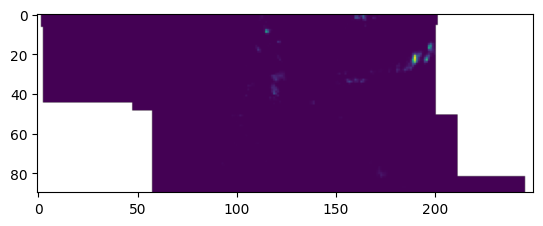

In [8]:
tiff = './dataset/2019/04/01/Radar_20190401000000.tif'

with rasterio.open(tiff) as image:
    image_array = image.read(1)
    num_neg_inf = np.sum(image_array == -np.inf)
    total_elements = image_array.size
    percentage_neg_inf = (num_neg_inf / total_elements) * 100
    print(f"Tỷ lệ phần trăm giá trị -inf: {percentage_neg_inf:.2f}%")

    image_array[image_array == -np.inf] = np.nan
    min_val = np.nanmin(image_array)
    max_val = np.nanmax(image_array)
    mean_val = np.nanmean(image_array)


    print(f"\nThông tin giá trị ảnh (không tính -inf):")
    print(f"  + Giá trị nhỏ nhất: {min_val}")
    print(f"  + Giá trị lớn nhất: {max_val}")
    print(f"  + Giá trị trung bình: {mean_val}")

    show(image_array)


Tỷ lệ phần trăm giá trị -inf: 28.63%

Thông tin giá trị ảnh (không tính -inf):
  + Giá trị nhỏ nhất: 0.0
  + Giá trị lớn nhất: 0.02500000037252903
  + Giá trị trung bình: 5.837847766088089e-06


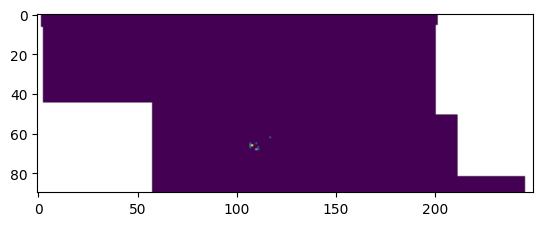

In [9]:
tiff = './dataset/2020/04/01/Radar_20200401000000.tif'

with rasterio.open(tiff) as image:
    image_array = image.read(1)
    num_neg_inf = np.sum(image_array == -np.inf)
    total_elements = image_array.size
    percentage_neg_inf = (num_neg_inf / total_elements) * 100
    print(f"Tỷ lệ phần trăm giá trị -inf: {percentage_neg_inf:.2f}%")
    image_array[image_array == -np.inf] = np.nan
    min_val = np.nanmin(image_array)
    max_val = np.nanmax(image_array)
    mean_val = np.nanmean(image_array)


    print(f"\nThông tin giá trị ảnh (không tính -inf):")
    print(f"  + Giá trị nhỏ nhất: {min_val}")
    print(f"  + Giá trị lớn nhất: {max_val}")
    print(f"  + Giá trị trung bình: {mean_val}")

    show(image_array)


# **Nhận xét**

*   Do phạm vi hoạt động của Radar có giới hạn nên ảnh Radar sẽ có những vùng
trắng có giá trị -inf.
*  Sử dụng nội suy lân cận



# **Fill khoảng trắng -inf**


*   Phương pháp 1: Fill với giá trị min = 0
*   Phương pháp 2: Sử dụng nội suy lân cận (nearest-neighbor interpolation)



In [10]:
def fill_inf_with_finite_image(image):

    min_finite = np.min(image[np.isfinite(image)])
    image[np.isneginf(image)] = min_finite
    return image

In [11]:
def fill_inf_with_interpolation(image):
    h, w = image.shape
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    #take valid points
    valid_mask = np.isfinite(image)
    valid_points = np.column_stack((X[valid_mask], Y[valid_mask]))
    valid_values = image[valid_mask]

    #take inf points
    inf_mask = np.isneginf(image)
    inf_points = np.column_stack((X[inf_mask], Y[inf_mask]))

    #interpolation
    interpolated_values = griddata(valid_points, valid_values, inf_points, method='nearest')


    filled_image = image.copy()
    filled_image[inf_mask] = interpolated_values

    return filled_image

[      -inf       -inf 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

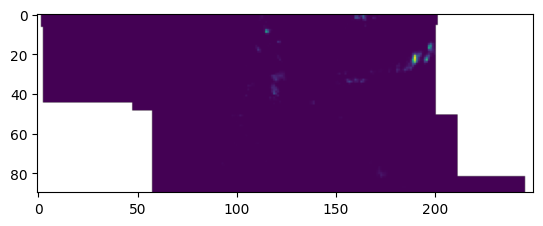

In [12]:
tiff = './dataset/2019/04/01/Radar_20190401000000.tif'

with rasterio.open(tiff) as image:
    image_array = image.read(1)

    print(image_array[0])
    show(image_array)


# **Fill với giá trị min = 0**

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

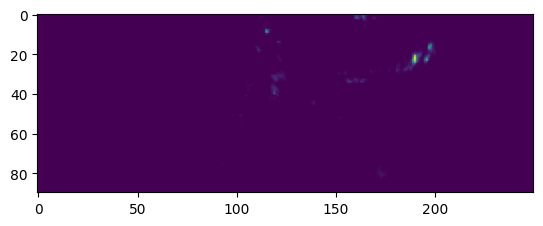

<Axes: >

In [13]:
image_array_fix_1 = fill_inf_with_finite_image(image_array)
print(image_array_fix_1[0])
show(image_array_fix_1)

# **Sử dụng nội suy lân cận (nearest-neighbor interpolation)**

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

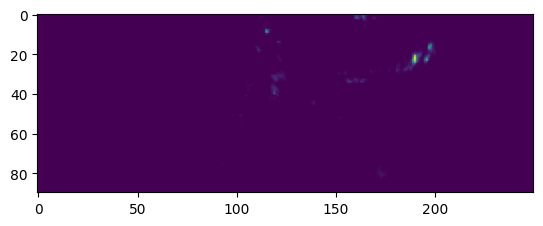

<Axes: >

In [14]:
image_array_fix_2 = fill_inf_with_interpolation(image_array)
print(image_array_fix_2[0])
show(image_array_fix_2)